In [1]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# 請輸入資料夾之所在位置
# e.g. 'Colab\ Notebooks/SC201Assignment4_2'
FOLDERNAME = 'Colab\ Notebooks/SC201Assignment4_2'

assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
files_loc = '/content/drive/MyDrive/{}'.format(FOLDERNAME)
sys.path.append(files_loc)

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/MyDrive/$FOLDERNAME/sc201/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SC201Assignment4_2/sc201/datasets
--2024-03-14 03:42:08--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  25.8MB/s    in 7.0s    

2024-03-14 03:42:15 (23.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Multiclass Classification

## Neural Network Model

大家之前遇到的 classification problem 是所謂的二元分類 binary classification，例如：將影評歸類為好評或差評。但並不是所有東西都適合做二元分類。要是有多種 classes，這時候應該如何進行分類？

Multiclass classification 的任務可以透過 neural network 來完成。大家會在這份作業中寫出一套 fully-connected neural network，並將其套用在 CIFAR-10 圖像資料庫上。CIFAR-10 資料庫顧名思義有十種類別的圖像，詳細介紹請參考：https://www.cs.toronto.edu/~kriz/cifar.html

我們在 `classifiers/neural_net.py` 中定義了 `TwoLayerNet` 類別以實現這套神經網路。神經網路的架構如下：
- Input layer：這是我們的 data，例如：圖像中的所有畫素。我們用 $D$ 表示每筆 data 的長度 (畫素的數量)，$N$ 表示 data 的數量 (圖像的數量)。
- Hidden layer：接收 data 的第一層 fully connected layer，權重 weight 和偏差 bias 名為 W1 和 b1。假設 hidden layer 有 $H$ 個神經元，那麼 W1 和 b1 的大小分別為 $(D, H)$ 和 $(H,)$。
- ReLU：常見的 activation function 之一，使這套網路變成非線性的必要元素。ReLU 會過濾掉 hidden layer 的 $H$ 個神經元中任何小於零的 neuron。
- Output layer：接收 ReLU 輸出的第二層 fully connected layer，權重和偏差名為 W2 和 b2，大小分別為 $(H, C)$ 和 $(C,)$。我們用 $C$ 表示類別的數目。

神經網路除了最底層的 input，共有兩層神經元，故稱作 `TwoLayerNet`。這兩層神經元的 W1、b1、W2 和 b2 參數儲存於 `self.params` 字典，字典的 key 是參數名稱，value 是 numpy 矩陣。

以 CIFAR-10 當作 data 為例，每張圖像有 $32 \times 32 \times 3 = 3072$ 個畫素，且共有十種圖像類別，所以 $D = 3072$，$C = 10$，$N$ 和 $H$ 可以由我們任意決定。

Output layer 輸出的 $C$ 個數值，是不是與我們的 $C$ 種類別有所關聯呢？是的，output layer 輸出的結果我們稱之為 class scores，以 $f_j | j = 0, 1, \ldots, C-1$ 表示，每一個數值 $f_j$ 是 data 被歸類為第 $j$ 類別之分數，分數最高的就是最有可能的類別。

## Softmax Loss

我們現在知道如何用這套模型做 prediction，但是要先訓練過模型才能夠做預測。這時候就要定義 cost function，並反覆執行 forward 與 backward pass 做 gradient descent，以找出 cost function 的最低點。我們可以從 binary classification 的 loss function 推導出一個適合 multiclass classification 的 cost function。

之前在 binary classification (i.e. $C = 2$，logistic regression) 所使用的 loss function 為：

$$L^{(i)} = \begin{cases}
- \log (1 - h^{(i)}) & \quad \text{if } y^{(i)} = 0 \\
- \log h^{(i)} & \quad \text{if } y^{(i)} = 1
\end{cases} $$

$y^{(i)}$ 是第 $i$ 筆 data 的正確類別，$0 \leq i \leq N - 1$。而 $0 \leq h^{(i)} \leq 1$ 是模型的預測，也就是 data 被歸類為類別 $1$ 的機率，$1 - h^{(i)}$ 則是 data 被歸類為類別 $0$ 的機率。假設我們使用上面的神經網路取得 class scores $f_0^{(i)}$ 和 $f_1^{(i)}$，那這些分數跟機率 $1 - h^{(i)}$ 和 $h^{(i)}$ 又有什麼關係？畢竟 output layer 輸出的數值不一定介於 $0$ 跟 $1$ 之間，所以我們不能直接把 class score 當成是機率。但是我們可以使用所謂的 softmax function，將 class scores 標準化 (normalization)，使它們的和為 $1$：

$$ \sigma(f_j^{(i)}) = \frac{\exp (f_j^{(i)})}{\sum_{k=0}^{C-1} \exp (f_k^{(i)})} $$

例如：當 $C = 2$ 時，$ \sigma(f_0^{(i)}) = \frac{\exp (f_0^{(i)})}{\exp (f_0^{(i)}) + \exp (f_1^{(i)})} $，$ \sigma(f_1^{(i)}) = \frac{\exp (f_1^{(i)})}{\exp (f_0^{(i)}) + \exp (f_1^{(i)})} $。大家可以自行驗證 $ 0 \leq \sigma(f_j^{(i)}) \leq 1 $，$ \sum_{j=0}^{C-1} \sigma(f_j^{(i)}) = 1 $。

這時候我們就可以將 $\sigma(f_j^{(i)})$ 視成 data 屬於第 $j$ 個類別的機率！

所以 $1 - h^{(i)} = \sigma(f_0^{(i)})$，$h^{(i)} = \sigma(f_1^{(i)})$。我們可以重整 binary loss function 如下：

$$ L^{(i)} = - \log \sigma(f_y^{(i)}) = - \log \left ( \frac{\exp (f_y^{(i)})}{\sum_{k=0}^1 \exp (f_k^{(i)})} \right ) $$

這樣大家就應該猜得出來 multiclass loss function 的公式了吧！

$$ L^{(i)} = - \log \sigma(f_y^{(i)}) = - \log \left ( \frac{\exp (f_y^{(i)})}{\sum_{k=0}^{C-1} \exp (f_k^{(i)})} \right ) $$

最後，我們將所有 data 的 loss 加起來取平均，得到 multiclass cost function：

$$ J = \frac{1}{N} \sum_i L^{(i)} $$

當我們的模型能夠更準確的預測出第 $i$ 筆 data 的所屬類別 $y^{(i)}$ 時，$y^{(i)}$ 的 class score $f_y^{(i)}$ 會比其他 $f_j^{(i)} | j \neq y^{(i)}$ 來的大，loss $L^{(i)}$ 也會跟著下降，反之亦然。所以只要我們對於 $J$ 做 gradient descent，模型就會進步！

這個 loss function 公式我們稱作 softmax loss。有了 softmax loss，就可以訓練出強大的 multiclass 模型，然後拿來做預測！

# Implementing a Neural Network


In [3]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
%cd drive/MyDrive/$FOLDERNAME
from sc201.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/content/drive/MyDrive/Colab Notebooks/SC201Assignment4_2


撰寫程式的過程中，我們先將 CIFAR-10 擱置在旁，暫時使用虛構的 toy data 來做測試。我們透由下方的 code 來建立一組 toy data 並初始化大家接下來會完成的 toy model。注意 toy data 和 toy model 對應的矩陣大小不一定跟 CIFAR-10 的一樣。

In [4]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
請開啟 `classifiers/neural_net.py`。檔案中的 `TwoLayerNet.cost` 函數：
- Input 為 training data 和 `self.params` 中的 weights 和 biases、
- Output 為 class scores，或是 cost 和 gradients。

請寫出 forward pass 的第一步驟，利用神經網路的 weights 和 biases 計算出 class scores。

In [5]:
scores = net.cost(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
接下來請寫出 forward pass 的第二步驟，計算出 softmax loss 及總和 cost。

### Hint 1：###

在計算

$$ \sigma(f_y^{(i)}) = \frac{\exp (f_y^{(i)})}{\sum_{k=0}^{C-1} \exp (f_k^{(i)})} $$

的時候，如果 neural network 輸出的 class scores 很大，$e^{f_y^{(i)}}$ 和 $\sum_{k=0}^{C-1} e^{f_k^{(i)}}$ 也會跟著變大，電腦相除時可能會因為不穩定而出錯。這時候，我們可以從每個 class score 扣除固定的常數 $A$：

$$ \sigma(f_y^{(i)}) = \frac{\exp (f_y^{(i)} - A)}{\sum_{k=0}^{C-1} \exp (f_k^{(i)} - A)} $$

大家可以自行確認兩條式子是相等的。

$A$ 可以由我們任意決定。我們通常會將 $A$ 設為 $\max_k f_k^{(i)}$，也就是將 class scores 平移，使最高的分數為零。

因此，大家的答案中應該會出現這一行 code：```scores -= np.amax(scores, axis = 1, keepdims = True)```

### Hint 2：###

另外，我們必須找出每筆資料 $i$ 的正確類別 $y^{(i)}$ 所對應的 class score $f_y^{(i)}$。這時候就可以使用以下的 numpy 語法：```scores[range(N), y]```

```range(N)``` 和 ```y``` 都是長度為 $N$ 的向量。這行 code 等同於 ```np.array([scores[i][y[i]] for i in range(N)])```

In [6]:
cost, _ = net.cost(X, y)
correct_cost = 1.265857052118

# should be very small, we get < 1e-12
print('Difference between your cost and correct cost:')
print(np.sum(np.abs(cost - correct_cost)))

Difference between your cost and correct cost:
5.3512749786932545e-14


# Backward pass
請寫出函數中剩餘的 backward pass 步驟，計算出 cost 對於 `W1`、`b1`、`W2` 和 `b2` 的梯度。我們可以利用上面完成的 forward pass 來估測 gradient 的數值，與 backward pass 的結果做相比。

### Hint：###

Softmax loss function 對於 class scores 的偏微分如下：

$$ \frac{\partial L^{(i)}}{\partial f_j^{(i)}} = \begin{cases}
\sigma(f_j^{(i)}) - 1 & \quad \text{if } j = y^{(i)} \\
\sigma(f_j^{(i)}) & \quad \text{else}
\end{cases}$$

所以 cost function 對於 class scores 的梯度應該這樣計算：

```python
sigma = np.exp(scores) / (np.sum(np.exp(scores), axis = 1, keepdims=True))
sigma[range(N), y] -= 1
grads_classScores = sigma / N # note: cost function has factor 1/N
```

Cost function 對於第二個偏差 b2 的梯度則是：```grads['b2'] = np.sum(grad_classScores, axis = 0)```

```grads``` 字典中應儲存的其餘（較為好寫的）三個梯度就請大家自己計算了。

In [7]:
from sc201.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

cost, grads = net.cost(X, y)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.cost(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 3.865091e-11
W2 max relative error: 6.368993e-10
b1 max relative error: 1.555470e-09
W1 max relative error: 4.475412e-09


# Train the network

Forward 和 backward pass 都完成後，就可以做 training 了。請完成：
- `TwoLayerNet.train` 函數，執行 Minibatch Gradient Descent、
- `TwoLayerNet.predict` 函數，讓 model 可以做出預測。

記得 Minibatch Gradient Descent (MBGD) 是介於一般 Batch Gradient Descent (BGD) 和 Stochastic Gradient Descent (SGD) 之間的 learning 模式，每一次做更新是從所有資料中隨機抽取固定數量的 Minibatch（樣本可重複）。而預測則是使用 forward pass 計算出 class scores 之後，回傳最大分數之對應類別。

### Hint：###
- 當您在執行 Minibatch Gradient Descent (MBGD) 時，可以試試「先製作一個空 list，隨機取出 X[i] 或 y[i] 加入 list，最後再把 list 轉換成 numpy array」即可。

- np.argmax 會在「 model 預測答案」時派上用場。歡迎參閱下方 numpy 官網連結了解該如何使用: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

寫完後請執行下方的 cell 來訓練出一套可以對 toy data 做出預測的 toy model。最終的 training cost 應小於 0.02。

Final training cost:  0.01480533169891632


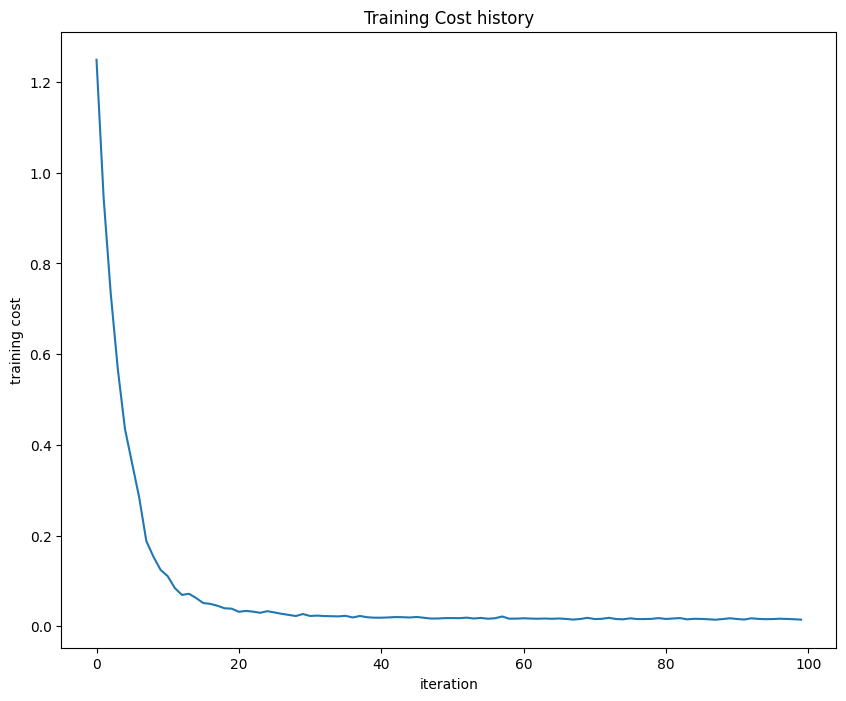

In [8]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, num_iters=100,
            verbose=False)

print('Final training cost: ', stats['cost_history'][-1])

# plot the cost history
plt.plot(stats['cost_history'])
plt.xlabel('iteration')
plt.ylabel('training cost')
plt.title('Training Cost history')
plt.show()

# Load the data

大家寫好的 neural network 類別通過了 toy data 的測試，蓄勢待發！接下來我們將 dataset 升級為 CIFAR-10，用真實的 data 訓練出強大的模型！

In [9]:
from sc201.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'sc201/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
這次的訓練過程中，我們會在每個 epoch 結束後，將 learning rate 乘上一個固定係數，以達成指數衰減 (exponential decay)。這是為了控制 training 後期的 step size，以達成收斂。Decay 的部分已經幫大家寫好了，請直接執行下面的 cell。

In [10]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: cost 2.302564
iteration 100 / 1000: cost 2.302140
iteration 200 / 1000: cost 2.299567
iteration 300 / 1000: cost 2.270188
iteration 400 / 1000: cost 2.210385
iteration 500 / 1000: cost 2.127371
iteration 600 / 1000: cost 2.064137
iteration 700 / 1000: cost 2.039243
iteration 800 / 1000: cost 2.066566
iteration 900 / 1000: cost 1.895066
Validation accuracy:  0.282


# Debug the training

使用上方的預設參數的情況下，大家應該會看到 validation accuracy 大約為 0.29。這並不是很理想的結果...

我們可以觀察 training 和 validation 在每個 epoch 的 cost 和 accuracy，以做診斷，或是以圖像的方式畫出 neural network 直接接收 input 的第一層 layer，也就是 hidden layer 的權重。大家或許可以從權重的圖像中看出一些輪廓...


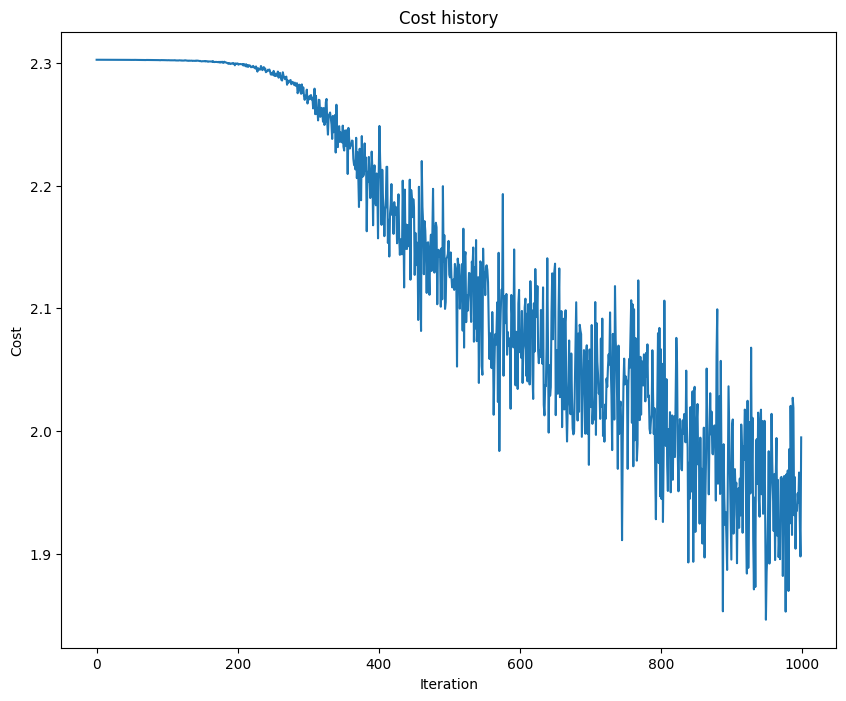

In [11]:
# Plot the cost function
plt.plot(stats['cost_history'])
plt.title('Cost history')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

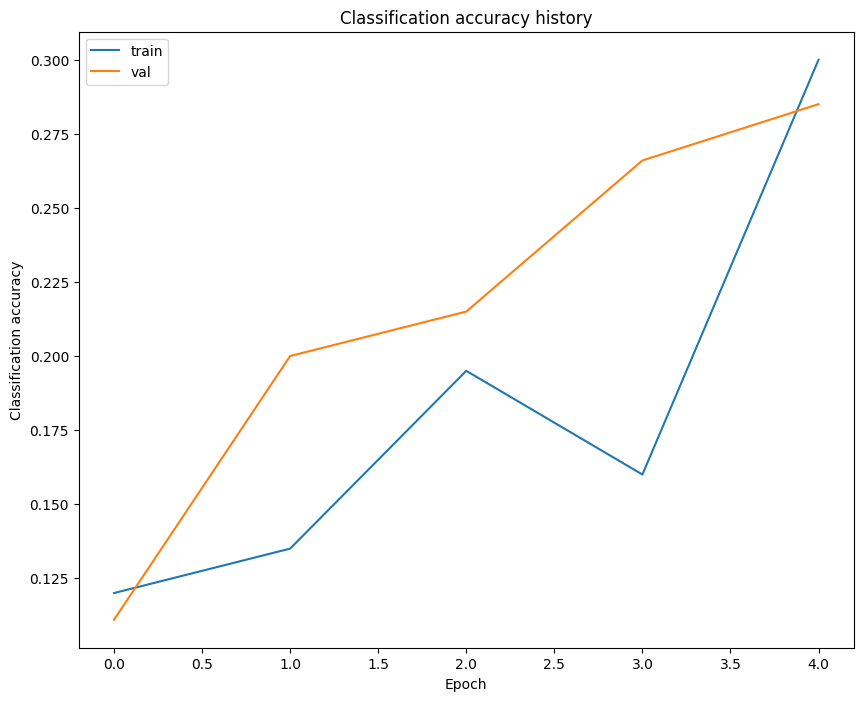

In [12]:
# Plot the train / validation accuracies
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

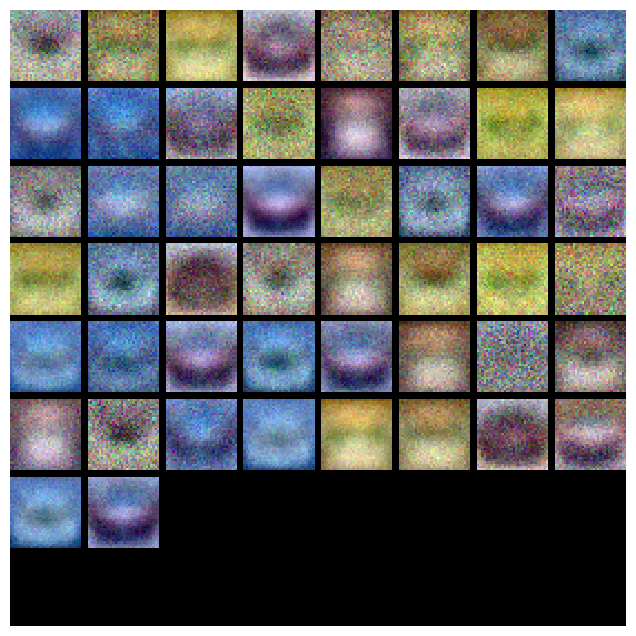

In [13]:
from sc201.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

### What's wrong：###
上方的 cost 大概是以線性的方式在下降，這意味著 learning rate 可能太低。

另外，training 和 validation 的準確率幾乎是一樣的，這意味著我們的 model 可能太小。

(相反的，如果 training 和 validation 的準確率相差太大，就有可能是 model 太大導致 overfitting。)


### Tuning：###
Hyperparameter tuning 是 AI 的一大環節，我們在這裡可以調整的 hyperparameters 為：

- hidden layer size $H$、
- mini-batch size、
- learning rate、
- learning rate decay schedule。

$\color{red}{注意：請勿調整}$ num_iters

大家可以針對上面觀測到的問題，對這些 hyperparameters 做調整，將最好的模型儲存於 `best_net`。最終的 validation accuracy 應該要達到 48% 以上。

In [92]:
best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Create a random generator object
rng = np.random.default_rng(seed=42)

# Define the hyperparameter ranges as lists
hidden_size_options = [80, 90]
learning_rate_options = [1e-3]
batch_size_options = [100, 200]
learning_rate_decay_options = [0.98, 0.99]

# Number of random trials
num_random_trials = 5

# Initialize variables to track the best model and its validation accuracy
best_net = None
best_val_acc = -1

# Conduct the random search
for trial in range(num_random_trials):
    # Randomly select hyperparameters using the new Generator API
    hidden_size = rng.choice(hidden_size_options)
    learning_rate = rng.choice(learning_rate_options)
    batch_size = rng.choice(batch_size_options)
    learning_rate_decay = rng.choice(learning_rate_decay_options)

    # Create a new model with the randomly selected hyperparameters
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the model on the training data
    stats = net.train(X_train, y_train, X_val, y_val,
              num_iters=1000, batch_size=batch_size,
              learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
              verbose=False)

    # Evaluate the model
    train_acc = (net.predict(X_train) == y_train).mean()
    val_acc = (net.predict(X_val) == y_val).mean()

    # If this model is the best so far, update best_net and best_val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net
        best_history = stats

    # Print out the current hyperparameters and the achieved validation accuracy
    print(f'Trial {trial + 1}/{num_random_trials} - val accu: {val_acc:.2f} - ' +
          f'train acc: {train_acc:.2f} - '
          f'hidden_size: {hidden_size}, lr: {learning_rate}, ' +
          f'batch_size: {batch_size}, lr_decay: {learning_rate_decay}')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Trial 1/5 - val accu: 0.48 - train acc: 0.51 - hidden_size: 80, lr: 0.001, batch_size: 200, lr_decay: 0.99
Trial 2/5 - val accu: 0.44 - train acc: 0.47 - hidden_size: 80, lr: 0.001, batch_size: 100, lr_decay: 0.99
Trial 3/5 - val accu: 0.48 - train acc: 0.51 - hidden_size: 80, lr: 0.001, batch_size: 200, lr_decay: 0.98
Trial 4/5 - val accu: 0.48 - train acc: 0.50 - hidden_size: 80, lr: 0.001, batch_size: 200, lr_decay: 0.99
Trial 5/5 - val accu: 0.49 - train acc: 0.51 - hidden_size: 90, lr: 0.001, batch_size: 200, lr_decay: 0.99


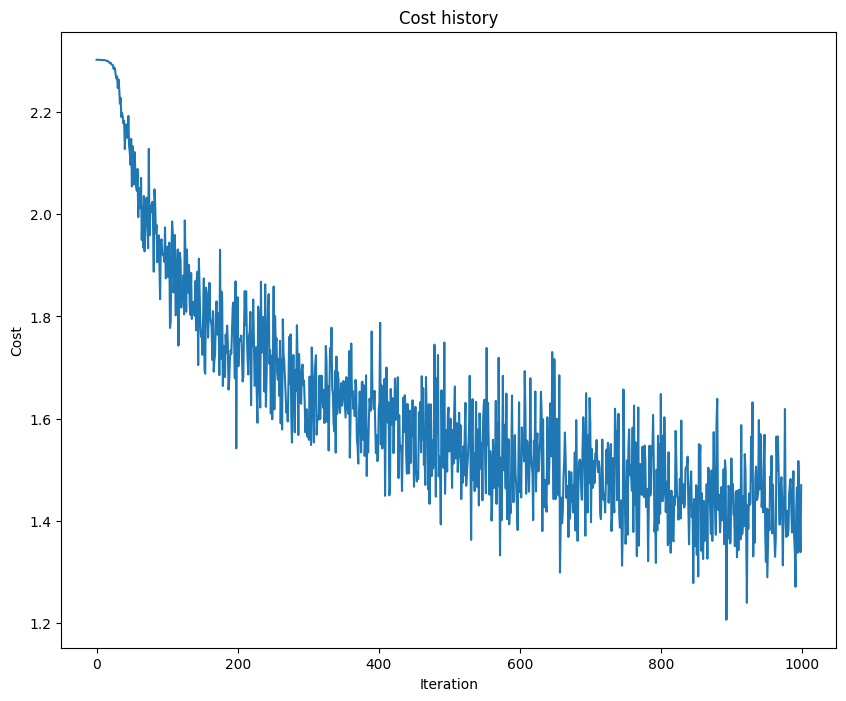

In [94]:
# Plot the cost function
plt.plot(stats['cost_history'])
plt.title('Cost history')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

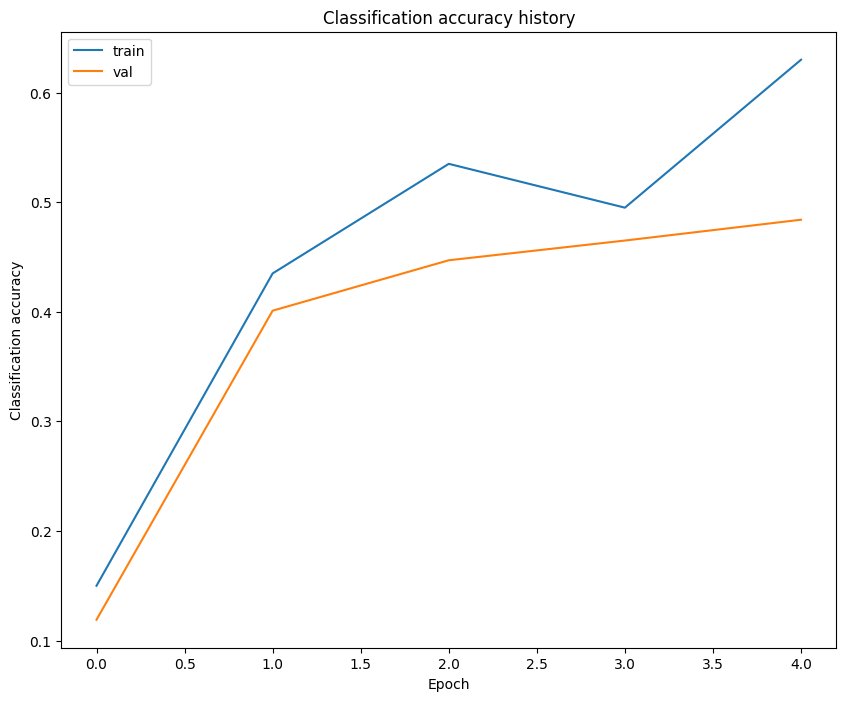

In [95]:
# Plot the train / validation accuracies
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [96]:
# Print your validation accuracy: this should be above 48%
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.489


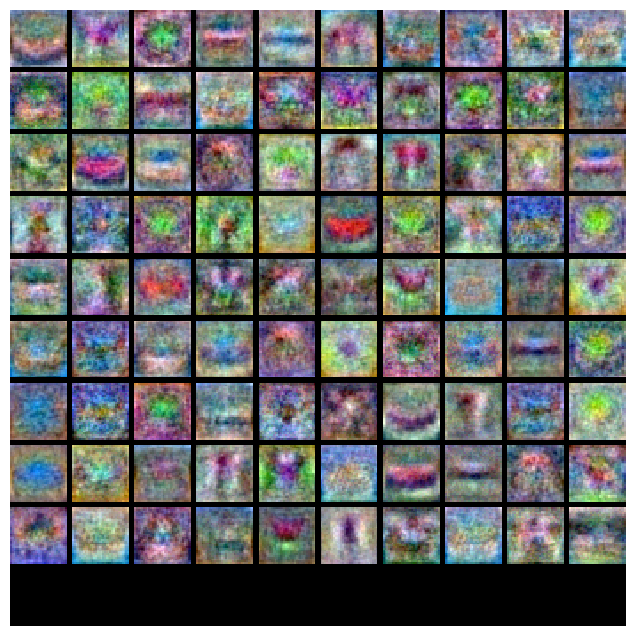

In [97]:
# Visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set

我們最後用 test data 來測試 `best_net`。Test accuracy 應該為 48% 以上。

In [93]:
# Print your test accuracy: this should be above 48%
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.483


---
# IMPORTANT
恭喜大家完成作業！ **Please make sure you save this notebook `Assignment4_2.ipynb` and `neural_net.py`!**

請直接分享您 SC201_Assignment4-2 $\color{red}{資料夾的連結}$！並將連結提交至作業繳交表單